[*********************100%***********************]  1 of 1 completed


 Tradebook Generated Successfully


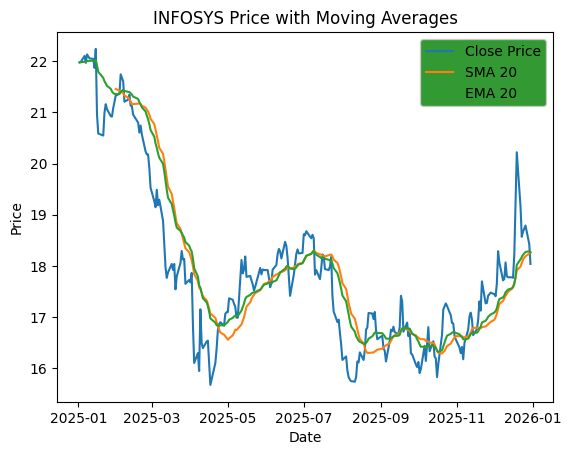

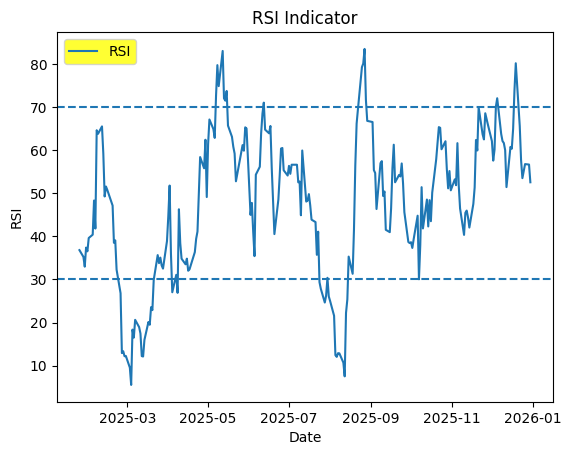

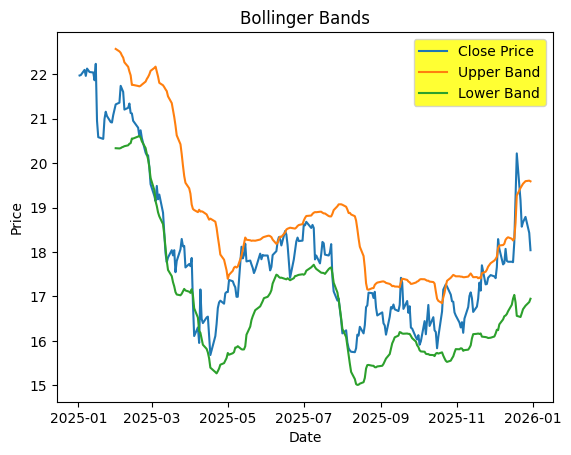

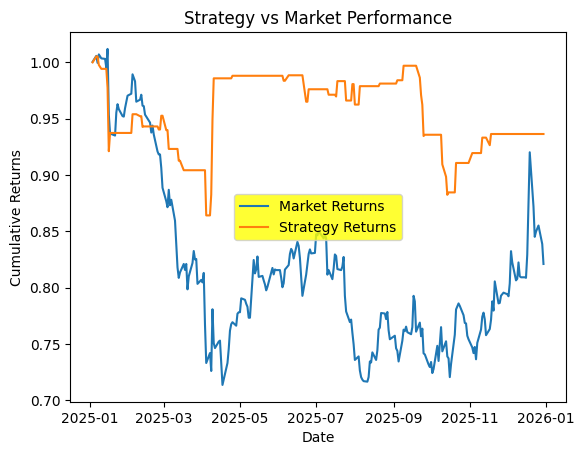

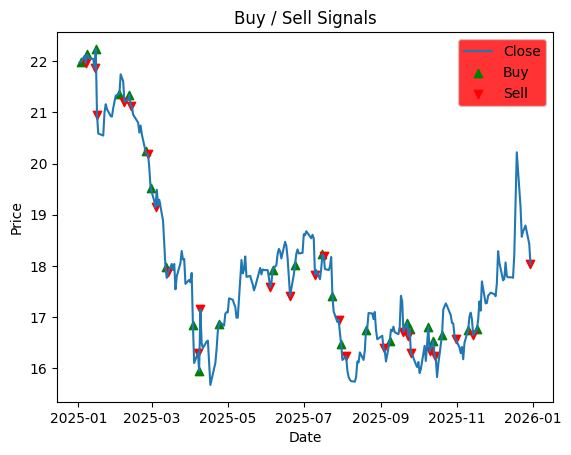

In [5]:
import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


# DATA FETCH
ticker = "infy"
start_date = "2025-01-01"
end_date = "2025-12-31"

df = yf.download(ticker, start=start_date, end=end_date)

# FIX multi-index columns
df.columns = df.columns.get_level_values(0)

df = df[['Open', 'High', 'Low', 'Close', 'Volume']]
df.dropna(inplace=True)
df.reset_index(inplace=True)

close = df['Close'].tolist()

# INDICATORS (FROM SCRATCH)

def sma(series, window):
    sma = []
    for i in range(len(series)):
        if i < window -1:
            sma.append(np.nan)
        else:
            sma.append(np.mean(series[i - window + 1 : i + 1]))

    return sma

def ema(series, window):
    k = 2 / (window + 1)
    ema_vals = [series[0]]
    for i in range(1, len(series)):
      ema_vals.append(series[i]*k + ema_vals[i-1]*(1-k))
    return ema_vals

def rsi(series, period=14):
    gains, losses, = [], []
    for i in range(1, len(series)):
        diff = series[i] - series[i-1]
        gains.append(max(diff, 0))
        losses.append(abs(min(diff, 0)))

    rsi_vals = [None]*period
    for i in range(period, len(series)):
        avg_gain = sum(gains[i-period:i]) / period 
        avg_loss = sum(losses[i-period:i]) / period
        if avg_loss == 0:
            rsi_vals.append(100)
        else:
            rs = (avg_gain) / (avg_loss)
            rsi_vals.append(100 - (100/(1+rs)))
    return rsi_vals

def macd(series):
    ema12 = ema(series, 12)
    ema26 = ema(series, 26)
    macd_line = [ema12[i] - ema26[i] 
  for i in range(len(series))]
    signal = ema(macd_line, 9)
    return macd_line, signal

def bollinger(series, window=20):
    upper, lower = [], []
    for i in range(len(series)):
        if i < window-1:
            upper.append(np.nan)
            lower.append(np.nan)
        else:
            data = series[i-window+1:i+1]
            mean = sum(data) / window
            std = np.std(data)
            upper.append(mean + 2*std)
            lower.append(mean - 2*std)
    return upper, lower
# CALCULATE INDICATORS


df['SMA_20'] = sma(close, 20)
df['EMA_20'] = ema(close, 20)
df['RSI_14'] = rsi(close)
df['MACD'], df['MACD_Signal'] = macd(close)
df['BB_Upper'], df['BB_Lower'] = bollinger(close)

# SIGNAL GENERATION

signals = []

for i in range(len(df)):
    buy = 0
    sell = 0

    if df['Close'][i] > df['SMA_20'][i]: buy += 1
    if df['Close'][i] < df['SMA_20'][i]: sell -= 1

    if df['Close'][i] > df['EMA_20'][i]: buy += 1
    if df['Close'][i] < df['EMA_20'][i]: sell -= 1

    if df['RSI_14'][i] is not None:
        if df['RSI_14'][i] < 30: buy += 1
        if df['RSI_14'][i] > 70: sell -= 1

    if df['MACD'][i] > df['MACD_Signal'][i]: buy += 1
    if df['MACD'][i] < df['MACD_Signal'][i]: sell -= 1

    if df['BB_Lower'][i] is not None:
        if df['Close'][i] < df['BB_Lower'][i]: buy += 1
        if df['Close'][i] > df['BB_Upper'][i]: sell -= 1

    if buy >= 2:
        signals.append(1)
    elif sell <= -2:
        signals.append(-1)
    else:
        signals.append(0)

final_signal= []
prev_state = 0

for i in range(len(signals)):
    if signals[i] == 1 and prev_state != 1:
        final_signal.append(1) #BUY
        prev_state = 1
    elif signals[i] != 1 and prev_state == 1:
        final_signal.append(-1) #SELL
        prev_state = 0
    else:
        final_signal.append(0) #HOLD

df['Final_Signal'] = final_signal

# SAVE TRADEBOOK

df[['Date','Close','SMA_20','EMA_20','RSI_14','MACD','MACD_Signal','BB_Upper','BB_Lower','Final_Signal']]\
  .to_csv("tradebook.csv", index=False)

print(" Tradebook Generated Successfully")

plt.figure()
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.plot(df['Date'], df['SMA_20'], label='SMA 20')
plt.plot(df['Date'], df['EMA_20'], label='EMA 20')

plt.title("INFOSYS Price with Moving Averages")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(facecolor = 'green')
plt.show()

plt.figure()
plt.plot(df['Date'], df['RSI_14'], label='RSI')

plt.axhline(30, linestyle='--')
plt.axhline(70, linestyle='--')

plt.title("RSI Indicator")
plt.xlabel("Date")
plt.ylabel("RSI")
plt.legend(facecolor = 'yellow')
plt.show()

plt.figure()
plt.plot(df['Date'], df['Close'], label='Close Price')
plt.plot(df['Date'], df['BB_Upper'], label='Upper Band')
plt.plot(df['Date'], df['BB_Lower'], label='Lower Band')

plt.title("Bollinger Bands")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(facecolor = 'yellow')
plt.show()

df['Returns'] = df['Close'].pct_change()
df['Strategy_Returns'] = df['Returns'] * df['Final_Signal'].shift(1)

market = (1 + df['Returns']).cumprod()
strategy = (1 + df['Strategy_Returns']).cumprod()

plt.figure()
plt.plot(df['Date'], market, label='Market Returns')
plt.plot(df['Date'], strategy, label='Strategy Returns')

plt.title("Strategy vs Market Performance")
plt.xlabel("Date")
plt.ylabel("Cumulative Returns")
plt.legend(facecolor = 'yellow')
plt.show()


plt.figure()
plt.plot(df['Date'], df['Close'], label='Close')

buy_signals = df[df['Final_Signal'] == 1]
sell_signals = df[df['Final_Signal'] == -1]

plt.scatter(buy_signals['Date'], buy_signals['Close'], marker='^', label='Buy', color = 'green')
plt.scatter(sell_signals['Date'], sell_signals['Close'], marker='v', label='Sell', color = 'red')

plt.title("Buy / Sell Signals")
plt.xlabel("Date")
plt.ylabel("Price")
plt.legend(facecolor = 'red')
plt.show()